In [1]:
import numpy as np 
from timeit import default_timer

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier, plot_line_points, plot_color_map
plot_prettier()

In [12]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_astropy(z, H0, Om0, OmL):
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    return cosmo.luminosity_distance(z=z) / u.Mpc

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

def plot_func_3d(x, y, z, xlabel=None, ylabel=None, zlabel=None, 
                 figsize=5., cmap=cm.coolwarm):

    fig = plt.figure(figsize=(figsize,figsize))
    ax = fig.add_subplot(111, projection='3d')

    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if zlabel is not None: ax.set_zlabel(zlabel)

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cmap,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(z.min(), z.max())
    plt.show()


### <font color='darkblue'>2D polynomial interpolation

Two-dimensional polynomial of order $m$ in the standard notation is given by:

$$p_m(x,y) = \sum\limits_{i=0}\sum\limits_{j=0}^{j+i\leq m} a_{ij}x^i y^j.$$

For example, quadratic 2D polynomial is 

$$p_2(x,y) = a_{00} + a_{01}y + a_{02}y^2 + a_{10}x + a_{20}x^2 + a_{11}xy$$

The same approach as for 1D polynomials, we need to have function values at $\geq 2(m+1)$ training points to solve for $2(m+1)$   coefficients.

In [159]:
# an example 2D polynomial 
xmin, xmax, nx = 1, 30, 60
ymin, ymax, ny = 1, 30, 60
x1, y1 = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
x2, y2 = np.meshgrid(x1, y1)
print(np.shape(x2), np.shape(y2))

z2 = x2**2 + 2*x2*y2 + y2**2

(60, 60) (60, 60)


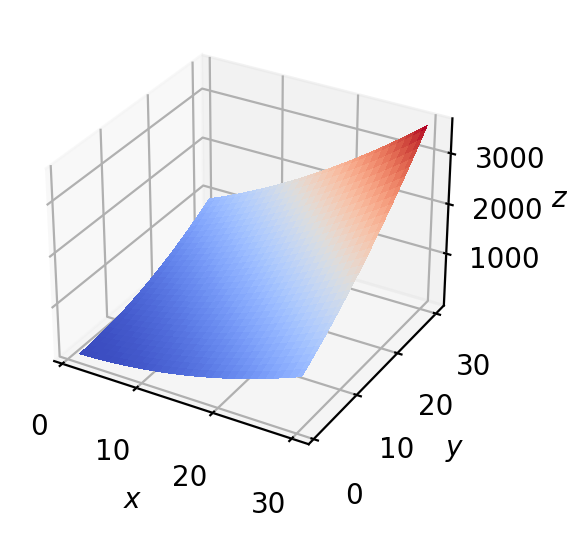

In [160]:
plot_func_3d(x2, y2, z2, figsize=3, xlabel='$x$', ylabel='$y$', zlabel='$z$')


### <font color='darkblue'>2D polynomial regression

By far the most common situation is that we have $N\gg m$ training points. This is because roundoff errors limit the largest $m$ we can use for 2D polynomials. 
    
    
In this case we use regression equations defined by the *least squares condition* similar to the condition that is used for 1D polynomial regression. 

In this case the problem is *overdetermined* and we construct approximation using least squares regression, similarly to how regression is done in 1d (see notebook 05_approximation_class). Least squares condition defines a system of $m$ equations for $m$ coefficients, which is solved by methods of linear algebra. 
    
In the function below this system is solved using Singular Value Decomposition (SVD) methods implemented in <tt>np.linalg.lstsq</tt>. 

In [332]:
def polyfit2d(xtr, ytr, ftr, order=None):
    '''
    Parameters:
        xtr, ytr - 1d numpy vectors with training points of x and y
        ftr - function values at xtr, ytr values
        order - int, order of the polynomial
        
    Returns:
        coefficients of the 2D polynomial
    '''
    # generate 2d coordinates on a rectangular grid
    x, y = np.meshgrid(xtr, ytr)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((order+1, order+1))
    # array that will contain polynomial term values 
    s = np.zeros((coeffs.size, x.size))

    # construct the 2D matrix of values for each polynomial term i, j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = x**i * y**j # coeffs[i, j] * 
        s[index] = arr.flatten() 
        
    # solve for the polynomial coefficients using least squares approximation of ftr values 
    return np.linalg.lstsq(s.T, np.ravel(ftr), rcond=None)[0]

def poly2d(xtest, ytest, a):
    '''
    Compute values of the 2D polynomial given the coefficients in 1d array a 
    at points given by 2d arrays xtest and ytest (generated using meshgrid)
    '''
    order1 = np.rint(a.size**0.5).astype(int)
    return np.polynomial.polynomial.polyval2d(xtest, ytest, a.reshape((order1,order1)))
    

In [8]:
# be careful with polynomial order, results quickly become unstable as order increases
order = 5

xmin, xmax, nx = 1, 30, 59
ymin, ymax, ny = 1, 60, 119
x1, y1 = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
x2, y2 = np.meshgrid(x1, y1)
z2 = x2**2 + 2*x2*y2 + y2**2

In [9]:
# get coefficients of best 2d polynomial
a = polyfit2d(x1, y1, z2, order=order)
zpoly = poly2d(x2, y2, a)

# set up test/validation points
nt = 200
xt, yt = np.linspace(xmin, xmax, nt), np.linspace(ymin, ymax, nt)
xgt, ygt = np.meshgrid(xt, yt)

# compute polynomial values on the grid of test points
ztpoly = poly2d(xgt, ygt, a)
ztexact = xgt**2 + 2*xgt*ygt + ygt**2 # compute exact values at the test points

Now let's plot polynomial approximation at test points as a 2D color map.

ferr_min = -9.1608e-05,  ferr_max = 1.9873e-05


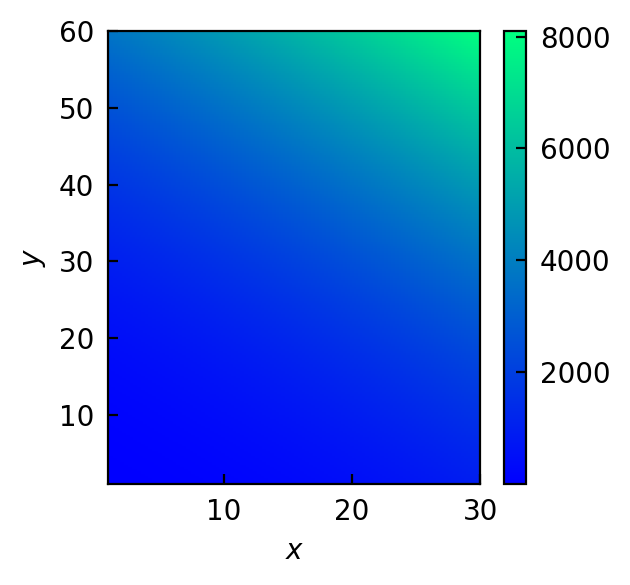

In [10]:
# print min and max fractional error
ferr_min, ferr_max = (ztpoly/ztexact-1).min(), (ztpoly/ztexact-1).max()
print(f'ferr_min = {ferr_min:.4e},  ferr_max = {ferr_max:.4e}')

# plot approximating polynomial
plot_color_map(xgt, ygt, ztpoly, xlim=[xmin,xmax], ylim=[ymin,ymax], 
                   xlabel = '$x$', ylabel = '$y$', cmap='winter', colorbar=True, 
                   figsize=3.0)

## <font color='blue'>Using polynomial regression to approximate $d_L(\Omega_{\rm m0},\Omega_\Lambda)$</font> 

The function below is a helper function to construct training and testing values of $d_L(\Omega_{\rm m0},\Omega_\Lambda)$ and its variables. 

In [97]:
# functions generating N+1 Chebyshev nodes of the 1st and 2nd kind 
# for input N, and interval edges a and b

def chebyshev_nodes1(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos((2.*np.arange(N)+1)*np.pi/(2.*(N+1))))

def chebyshev_nodes2(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos(np.arange(N)*np.pi/N))

In [337]:
# get training and test points 
ntrain, ntest = 10, 100
om0tr, omltr, om0t, omlt, dl_train, dl_test = get_dl_train_test(z=0.1, ntrain=ntrain, ntest=ntest)

# get grid of test values 
om0g, omlg = np.meshgrid(om0t, omlt)
dl_poly = poly2d(om0g, omlg, apc)

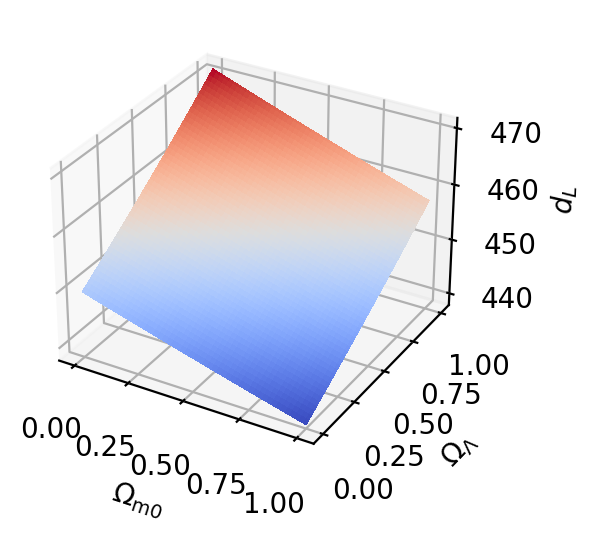

In [340]:
#%matplotlib notebook

plot_func_3d(om0g, omlg, dl_test.T, figsize=3, xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\Omega_\Lambda$', zlabel=r'$d_L$')

In [333]:
def get_dl_train_test(ntrain=15, ntest=100, z=1.0, H0=70., 
                      om0min=0., om0max = 1., omlmin=0., omlmax=1.,
                      spacing='even'):

    spacings = {'even': np.linspace, 'chebyshev1': chebyshev_nodes1, 'chebyshev2': chebyshev_nodes2}
    # generate training points 
    spacing_func = spacings[spacing]
    om0tr = spacing_func(om0min, om0max, ntrain)
    omltr = spacing_func(omlmin, omlmax, ntrain)
        
    dl_train = np.zeros((ntrain, ntrain)) # initialize 2D numpy array for 2D grid of d_L values     
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0tr):
        for j, omld in enumerate(omltr):
                dl_train[i,j] = d_l_astropy(z, H0, omd, omld)

    # test points             
    om0t = np.linspace(om0min, om0max, ntest)
    omlt = np.linspace(omlmin, omlmax, ntest)

    dl_test = np.zeros((ntest, ntest)) # initialize 2D numpy array for 2D grid of d_L values 
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0t):
        for j, omld in enumerate(omlt):
                dl_test[i,j] = d_l_astropy(z, H0, omd, omld)

    return om0tr, omltr, om0t, omlt, dl_train, dl_test

Get training and test values of $d_L$ and use training data to construct approximation to $d_L(\Omega_{\rm m0},\Omega_\Lambda)$ using 2d polynomial regression. 

In [343]:
# get training and test points 
ntrain, ntest = 7, 100
om0tr, omltr, om0t, omlt, dl_train, dl_test = get_dl_train_test(z=2, ntrain=ntrain, ntest=ntest)

order = 5 # polynomial order 
# get coefficients
apc = polyfit2d(om0tr, omltr, dl_train, order=order)

# get grid of test values 
om0g, omlg = np.meshgrid(om0t, omlt)
dl_poly = poly2d(om0g, omlg, apc)

ferr max = 2.813e-02


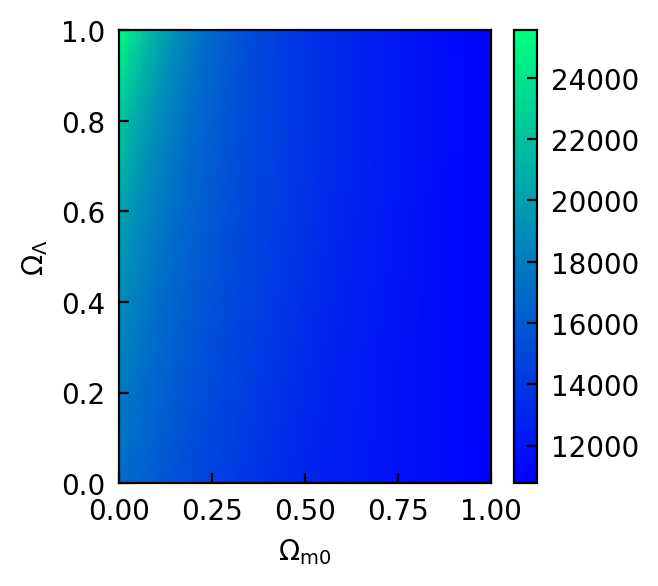

In [344]:
# plot approximating polynomial
ferr = np.abs(dl_poly/dl_test.T - 1.0)
print(f'ferr max = {ferr.max():.3e}')
plot_color_map(om0t, om0t, dl_poly, xlim=[0,1], ylim=[0,1], 
                   xlabel = r'$\Omega_{\rm m0}$', ylabel = r'$\Omega_\Lambda$', cmap='winter', colorbar=True, 
                   figsize=3.0)


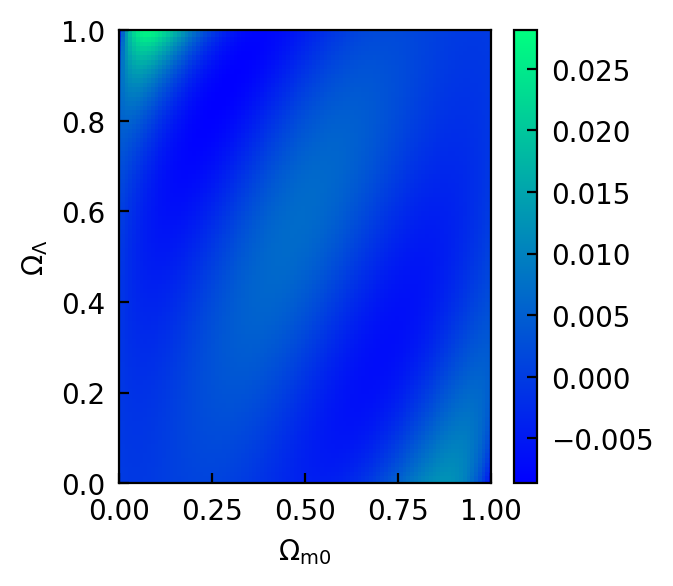

In [345]:
# plot fractional error
ferr = dl_poly/dl_test.T - 1.0
plot_color_map(om0t, om0t, ferr, xlim=[0,1], ylim=[0,1], 
                   xlabel = r'$\Omega_{\rm m0}$', ylabel = r'$\Omega_\Lambda$', cmap='winter', colorbar=True, 
                   figsize=3.0)

We can see that we obtained an approximation with accuracy well below $1\%$.  

Let's see how fast we can compute $d_L$ for random million pairs of parameter values. As you can see - a fraction of a second. This would take us hours if we were evaluating integral itself every time.  

In [346]:
nrand = 1000000
omr = np.random.uniform(size=nrand) # draw nrand random values of Om0 and OmL
omlr = np.random.uniform(size=nrand)

tstart = default_timer()
dlr = poly2d(omr, omlr, apc) # compute approximating polynomial for random pairs of Om0 and OmL
print("execution time = %.8g sec"%(default_timer()-tstart))


execution time = 0.1367038 sec


## <font color='blue'>Multivariate spline interpolation</font> 

Like in 1D, multivariate splines are constructed using piecewise low-order polynomials with coefficients constrained to maintain continuity of the spline derivatives of up to some order. 
   

In 2D splines, 2D polynomials like those considered above are used. For larger number of dimensions the number of coefficients and complexity of linear algebra calculations that are used to compute them increases. So spline approximations are typically limited to low dimensions ($\leq 4$). In fact in Python packages, only 2D spline approximation functions exist. 

Let's take a look at the functions available for multi-dimensional interpolation in <a href="https://docs.scipy.org/doc/scipy/reference/interpolate.html">scipy.interpolate</a>

#### <font color='darkblue'>Spline interpolation in 2D

Several functions for spline interpolation, but only in 2D (some of the useful "high-level" routines): 

* <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d"><tt>scipy.interpolate.interp2d</tt></a> - 2d spline interpolation with an interface similar to <tt>interp1d</tt>. 


* <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy.interpolate.RectBivariateSpline"><tt>scipy.interpolate.RectBivariateSpline</tt></a> - for spline approximation of points evenly spaced on a rectangular grid with a possibility of choosing smoothing parameter <tt>s</tt>, similarly to <tt>UnivariateSpline</tt> for 1d spline approximation.

    
* <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.SmoothBivariateSpline.html#scipy.interpolate.SmoothBivariateSpline"><tt>scipy.interpolate.SmoothBivariateSpline</tt></a> - 2d spline for arbitrarily spaced points with a possibility of choosing smoothing parameter <tt>s</tt>, similarly to <tt>UnivariateSpline</tt> for 1d spline approximation.

    
* <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LSQBivariateSpline.html#scipy.interpolate.LSQBivariateSpline"><tt>scipy.interpolate.LSQBivariateSpline</tt></a> - least squares regression with splines in 2D. 


### <font color='darkblue'>A text example: a 2D sine function 

Like in 1D, multivariate splines are constructed using piecewise low-order polynomials with coefficients constrained to maintain continuity of the spline derivatives of up to some order. 

In [347]:
def sin2d(x, y):
    return 0.5*(np.sin(x) + np.sin(y))

In [348]:
# construct 2d interpolating cubic spline given training values xtr, ytr, and ftr 
from scipy.interpolate import RectBivariateSpline

xmin, xmax, nx = 1, 30, 59
ymin, ymax, ny = 1, 30, 59
x1, y1 = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
x2, y2 = np.meshgrid(x1, y1)
zsin = sin2d(x2, y2)

# create an instance of a 2d spline interpolation object
# s = 0 forces interpolation instead of regression, kx, ky set order of spline polynomials (cubic here)
spl2d = RectBivariateSpline(x1, y1, zsin, s=0, kx=3, ky=3)

# compute spline approximation values at test points defined for polynomials above
zspl = spl2d(x1, y1)

Plot the function itself.

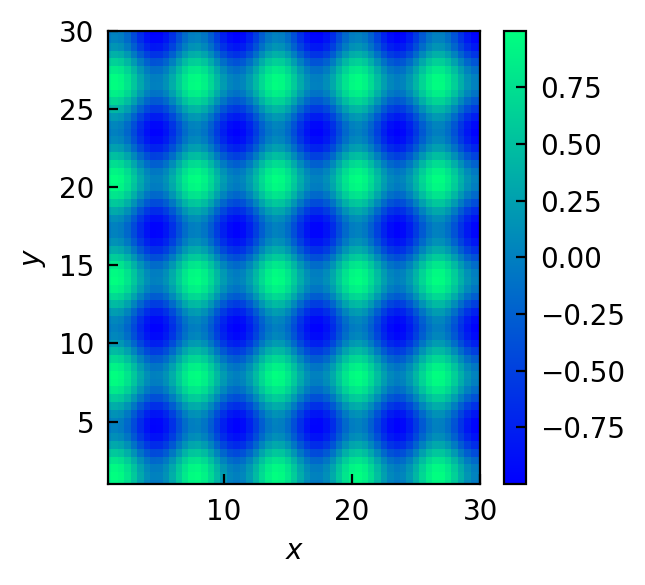

In [349]:
plot_color_map(x1, y1, sin2d(x2,y2), xlim=[xmin,xmax], ylim=[ymin,ymax], 
                   xlabel = '$x$', ylabel = '$y$', cmap='winter', colorbar=True, 
                   figsize=3.0)

Plot the spline approximation

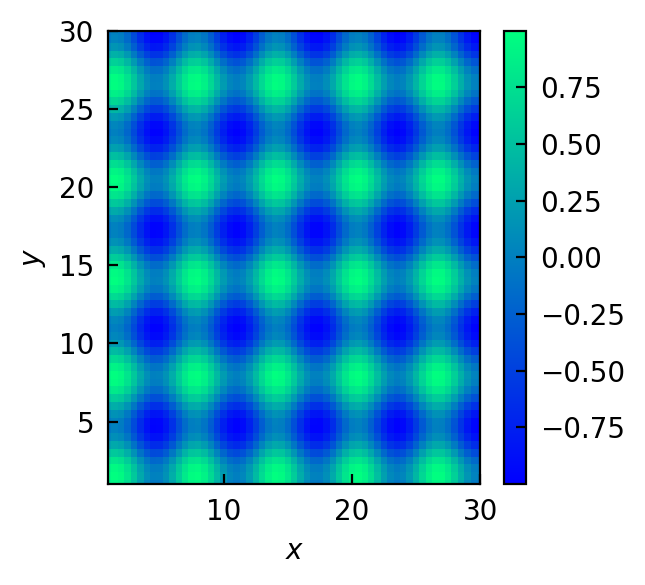

In [350]:
plot_color_map(x1, y1, zspl, xlim=[xmin,xmax], ylim=[ymin,ymax], 
                   xlabel = '$x$', ylabel = '$y$', cmap='winter', colorbar=True, 
                   figsize=3.0)

Plot fractional error

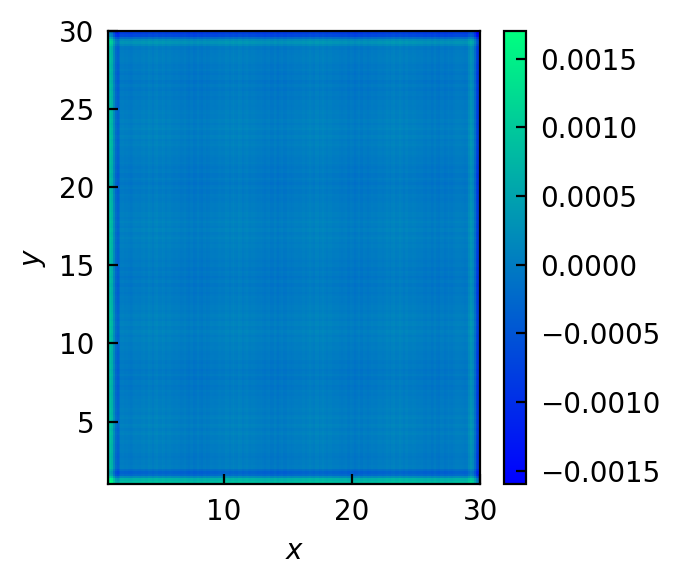

In [351]:
# plot approximation at test points as a color map
xmin, xmax, nx = 1, 30, 200
ymin, ymax, ny = 1, 30, 200
x1, y1 = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
x2, y2 = np.meshgrid(x1, y1)
zspl = spl2d(x1, y1)

plot_color_map(x1, y1, zspl-sin2d(x2,y2), xlim=[xmin,xmax], ylim=[ymin,ymax], 
                   xlabel = '$x$', ylabel = '$y$', cmap='winter', colorbar=True, 
                   figsize=3.0)

## <font color='blue'>Using spline interpolation to approximate $d_L(\Omega_{\rm m0},\Omega_\Lambda)$</font> 



Get training and test values of $d_L$ and use training data to construct approximation to $d_L(\Omega_{\rm m0},\Omega_\Lambda)$ using 2d polynomial regression. 

In [353]:
from scipy.interpolate import RectBivariateSpline

ntrain, ntest = 15, 100
om0tr, omltr, om0t, omlt, dl_train, dl_test = get_dl_train_test(ntrain=ntrain, ntest=ntest)

# create an instance of a 2d spline interpolation object
spl2d = RectBivariateSpline(om0tr, omltr, dl_train.T, s=0, kx=3, ky=3)

# compute spline approximation values at test points defined for polynomials above
dspl = spl2d(om0t, omlt)

ferr max = 7.712e-05


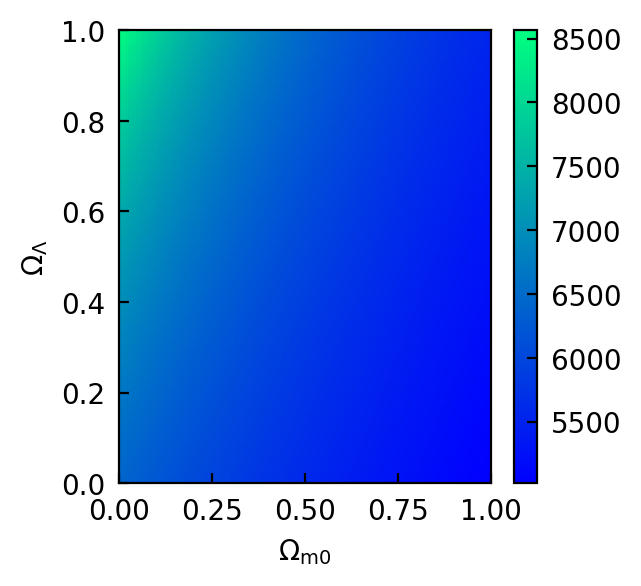

In [354]:
# plot approximating polynomial
ferr = np.abs(dspl/dl_test.T - 1.0)
print(f'ferr max = {ferr.max():.3e}')
plot_color_map(om0t, om0t, dspl, xlim=[0,1], ylim=[0,1], 
                   xlabel = r'$\Omega_{\rm m0}$', ylabel = r'$\Omega_\Lambda$', cmap='winter', colorbar=True, 
                   figsize=3.0)


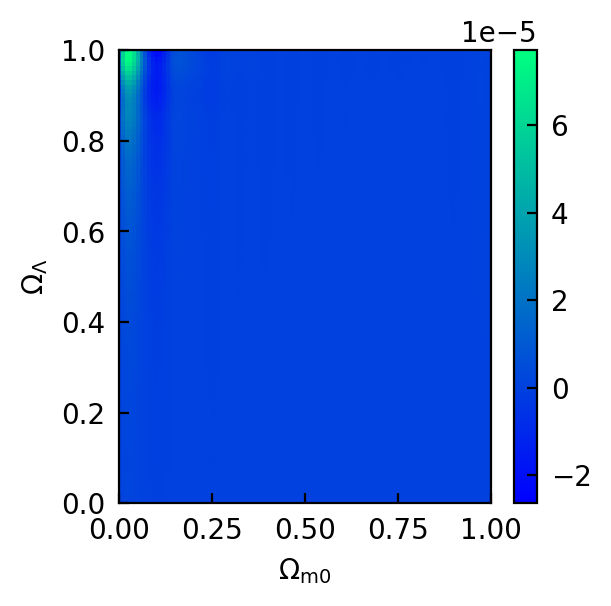

In [355]:
# plot fractional error
ferr = dspl/dl_test.T - 1.0
plot_color_map(om0t, om0t, ferr, xlim=[0,1], ylim=[0,1], 
                   xlabel = r'$\Omega_{\rm m0}$', ylabel = r'$\Omega_\Lambda$', cmap='winter', colorbar=True, 
                   figsize=3.0)

We can see that spline approximation is quite accurate.  

In [37]:
nrand = 1000000
omr = np.random.uniform(size=nrand)
omlr = np.random.uniform(size=nrand)

tstart = default_timer()
dlr = spl2d(omr, omlr, grid=False)
print("execution time = %.8g sec"%(default_timer()-tstart))


execution time = 0.1146112 sec


A bit slower than evaluating using polynomial approximation, but still very fast. 

### <font color='blue'>2d function approximation summary</font>

* Accurate methods developed for approximation of 1D functions work in 2D (with more care for smooth functions they also can work in 3D and 4D)
    
    
* The number of coefficients and the cost of calculations increases with increasing  polynomial order $m$ (as $2(m+1)$) or number of training points. 
    
    
* Polynomial approximation becomes numerically unstable (overflows/underflows) for larger order. 
    

* These factors make application of standard methods in >2D dimensions difficult generally, but such approximations are used for specific problems sometimes, especially with Chebyshev nodes. 
    

* Piecewise linear and spline approximations are numerically stable and robust methods for 2D approximation. 
    
    
* Some accurate methods for approximation of functions in >2D do exist (e.g., RBF), but tend to be computationally expensive. 
    

* Majority of applications of function approximation in >2D involve Machine Learning methods, which are often crude and approximate, but do scale well with increasing $D$. 

# <font color='blue'>ASTR 21100/31200

## <font color='blue'>Methods for finding minimum/maximum of a function (aka optimization)
## <font color='blue'>Derivative-free methods 

Optimization is numerical computations of the function parameter values, for which the function has minimum or maximum. 

Given that any maximum of $f(\mathbf{x})$ is a minimum of $-f(\mathbf{x})$, the actual methods focus on minimizing the function.

### <font color='blue'>Local minima vs global minimum</font>

A multi-dimensional function can have multiple peaks and valleys with minima. Usually, we are interested to find global minimum or maximum, while local extrema are a nuisance as they can fool an algorithm. 
    
<p>
<center>
<a href="http://nelder-mead.s3-website.us-east-2.amazonaws.com/"><img width=700 src="https://astro.uchicago.edu/~andrey/classes/a211/img/local_vs_global_min.PNG"></img></a>

### <font color='blue'>Other considerations for the optimization methods</font>


* Global minimization (find all minima) vs local minimization (find local minimum only) 


* Is the function discontinuous (discrete)? 


* Computational efficiency


* Robustness of the result: whether true minimum is found regardless of the starting guess


* Whether it is easy to impose boundaries on the values of the function parameters during minimum search


### <font color='blue'>A test case: sampling of the Rosenbrock "banana" distribution</font>

Rosenbrock distribution is described by the following equation in 2D (i.e. for two parameters $x$ and $y$): 

$$p_{\rm R}(x_1,x_2) = \exp\left[-c\,(b(x_2-x_1^2)^2 -(a-x_1)^2)\right], $$
    

which is often used for testing optimization and sampling algorithms, particularly with $a=1$, $b=100$ most often used. It has a global maximum at $(x_1,x_2)=(a,a^2)$ at which $p_{\rm R}(x_1,x_2)=1$, as is clear from the equation above. 

or logarithm of the function: 

$$\ln p_{\rm R}(x_1, x_2) = -c\, \left[b(x_{2}-x_{1}^2)^2 + (a-x_{1})^2\right]$$

***Note:*** The multi-dimensional extension of the Rosenbrock function for $d$-dimensional space of parameters $\mathbf{x}=\{x_0,x_1.\ldots,x_{d-1}\}$ is

$$p_{\rm R}(\vec{x}\vert a, b,c)=\exp\left(-c\times \sum\limits_{i=1}^{d-1}\left[b(x_{i}-x_{i-1}^2)^2 + (a-x_{i-1})^2\right]\right).$$

or

$$\ln p_{\rm R}(\vec{x}\vert a, b,c) = -c\times \sum\limits_{i=1}^{d-1}\left[b(x_{i}-x_{i-1}^2)^2 + (a-x_{i-1})^2\right]$$

This function is frequently used for testing of sampling and optimization algorithms  because this function is quite "difficult" despite its benign-looking functional form. The function spans a wide range of values over small change of parameters: it has a strongly "curved" ridge in the $x-y$ plane which extends  values to large values of $x$ and $y$. 

The function is named after Howard H. Rosenbrock, who introduced it as a test case for a minimization algorithm he developed in a <a href="https://academic.oup.com/comjnl/article/3/3/175/345501">paper</a> in 1960. 

Note that $-r(\mathbf{x})$ will be a function with a long curved "ridge" instead of "valley". Such function is often used in testing sampling algorithm and we will see it again when we talk about MCMC sampling. 

The routine below that was taken from the SciPy optimize package tutorials uses Python's vector slicing to calculate the function for $a=1$, $b=100$. Note that this implementation does not explicitly deal with dimensionality of the input vector $\mathbf{x}$, this is done automatically using vector operations. Thus, the same code works for $\mathbf{x}$ of different dimensions. Below we will use this function as a test case to find its minimum for 2D and 5D cases.    

The function below computes $\ln p_{\rm R}(\vec{x})$ and uses Python's vector slicing to calculate the function for $a=1$, $b=100$. Note that this implementation does not explicitly deal with dimensionality of the input vector $\mathbf{x}$, this is done automatically using NumPy vector operations. Thus, the same code works for $\mathbf{x}$ of different dimensions.    

In [361]:
import numpy as np 
from timeit import default_timer

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier, plot_2d_dist, plot_color_map
plot_prettier()

In [362]:
def mlnrosenbrock(x, a=1., b=100., c=1.):
    """-\ln of the Rosenbrock "banana" distribution
    x is a numpy vector of points in 2 or more dimensional space
    """
    return c * sum(b*(x[1:]-x[:-1]**2.0)**2.0 + (a-x[:-1])**2.0)

In [358]:
# define a grid of x and y for calculations and plotting
xmin, xmax, ng = -10, 10, 100
ymin, ymax = -50, 100
x = np.linspace(xmin, xmax, ng)
y = np.linspace(ymin, ymax, ng)

# generate a 2d grid of x and y points
xg, yg = np.meshgrid(x, y)

# form a single array of 2D vectors 
x = np.vstack([xg.ravel(), yg.ravel()])

# compute the Rosenbrock function and reshape the output into ng x ng grid for plotting
rg = mlnrosenbrock(x).reshape((ng,ng))


The colormap below shows logarithm (base-10) of the 2D Rosenbrock function. The minimum of the function is at $[x,y]=[1,1]$. 

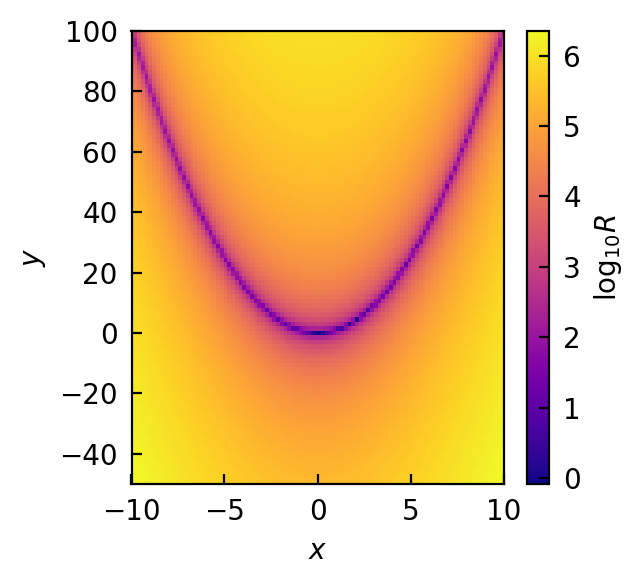

In [359]:
#xg, yg are 2D "grids" of x and y generated by meshgrid
# rg is 2D array with values of the Rosenbrock function for xg-yg grid

plot_color_map(xg, yg, np.log10(rg), xlim=[xmin,xmax], ylim=[ymin,ymax], 
                   xlabel = r'$x$', ylabel = '$y$', cmap='plasma', colorbar=True, 
                   contours=False, contcmap='plasma', cbar_label=r'$\log_{10} R$',
                   figsize=3.0)


### <font color='darkblue'>One of the simplest methods: Monte Carlo-based random walk minimization

Follows a random walk of a "*walker*" ($\mathbf{x}$ below is a vector of length $d$ - dimensionality of the parameter space where we are finding the minimum:

1. start at some initial point $\mathbf{x}=\mathbf{x}_0$. 

2. propose a step in a random direction $\mathbf{x}^\prime = \mathbf{x} + \Delta\mathbf{x}$

3. if $f(\mathbf{x}^\prime)< f(\mathbf{x})$, accept the step $\mathbf{x}=\mathbf{x}^\prime$, else go back to step 2.

Steps are terminated when some convergence is reached, for example no new step is accepted after some maximum number of proposed steps (it means that the walker is likely very close to the minimum), or accepted steps are smaller than some threshold. 


Choice of convergence criterion. Concept of ***the absolute tolerance*** parameter:

$$\mathtt{atol} > \max_{i=0,d-1}\vert x_i^\prime-x_i\vert$$ 

Components of the step vector $\Delta\mathbf{x}$ are usually chosen to follow Gaussian distribution, i.e. for a component $i$: 

$$p(\Delta x_i) = \frac{1}{\sqrt{2\pi}\,\sigma}\,\exp\left(-\frac{1}{2}\frac{\Delta x_i^2}{\sigma_i^2}\right) $$


The method requires choice of an optimal step sizes scale, $\sigma_i$. Performance and accuracy of the result will depend on this choice. However, this method is simple to implement, it does not require derivatives, and will do much better than the brute force search for a minimum. 

In [375]:
def minimize_by_random_walk(func, x0, stepsize, *args, atol=1.e-4, maxsteps=100, verbose=False):
    assert(atol > 0.) # ensure abs tolerance is positive
    nd = np.shape(x0)[0] # number of parameters
    xold = x0 + 100.*atol # initialize old location just to get things started
    xnew = x0 # initial position
    step = stepsize # initial step size
    chain = []
    nsteps = 0
    while np.abs(xnew - xold).max() > atol:
        xold = xnew
        fold = func(xold, *args)
        xtry = xold + np.random.normal(scale=step, size=nd) # generate a random Gaussian-distributed step
        while func(xtry, *args) >= fold:
            xtry = xold + np.random.normal(scale=step, size=nd)
        chain.append(xtry)
        xnew = xtry
        if verbose:
            print(xnew, np.abs(xnew - xold))
        nsteps += 1
        if nsteps > maxsteps: 
            print(f'maximum number of steps reached {maxsteps:d}')
            break

    return xnew, np.array(chain)

In [382]:
x0 = np.array([-2,2])
xmin, _ = minimize_by_random_walk(mlnrosenbrock, x0, 0.01, maxsteps=100, atol=1.e-3)
print(xmin)

maximum number of steps reached 100
[-1.35299037  1.85530852]


###  <font color='blue'>The Nelder-Mead (aka simplex) method</font>

There is no need for you to understand this algorithm in detail for our purposes. Just get the main idea.  Visual illustration of the algorithm, which can be found <a href="https://www.benfrederickson.com/numerical-optimization/">here</a>, can help with that.

The algorithm begins by forming an inital $(D + 1)$-dimensional polyhedron (where $D$ is the number of the minimized function parameters), or *simplex*,
of $D + 1$ points, $\mathbf{x}_i$, $i = 0, 1,\ldots, D$, that are randomly distributed throughout
the problem space domain. Indices of the points are sorted in ascending order of $f(\mathbf{x})$ so that $f(\mathbf{x}_0)$ is smallest and
$f(\mathbf{x}_D)$ is largest. It then proceeds as follows: 

1. To obtain a new trial point, $\mathbf{x}_r$, the worst point, $\mathbf{x}_D$, is reflected through the opposite face of the polyhedron using a scaling factor, $s_1$:

$$\mathbf{x}_r=\mathbf{x}_D + s_1\,(\mathbf{x}_m - \mathbf{x}_D),$$

where $\mathbf{x}_m$ is mean (the centroid) of all $\mathbf{x}$, excluding $\mathbf{x}_D$:

$$\mathbf{x}_m = \frac{1}{D}\,\sum\limits_{i=0}^{D-1}\mathbf{x}_i.$$

For example, when $D = 2$, the simplex is a triangle.

2. If $f(\mathbf{x}_r)<f(\mathbf{x}_0)$, then take another step in the same direction with scaling factor of $s_2$:

$$\mathbf{x}_e=\mathbf{x}_r + s_2\,(\mathbf{x}_m - \mathbf{x}_D),$$

If $f(\mathbf{x}_e)<f(\mathbf{x}_0)$, then $\mathbf{x}_D=\mathbf{x}_e$ and we go to step 1 above, else
    $\mathbf{x}_D=\mathbf{x}_r$.
    
3. Else if $f(\mathbf{x}_r)>f(\mathbf{x}_0)$, compare $f(\mathbf{x}_r)$ to $f(\mathbf{x}_{D-1})$ and if $f(\mathbf{x}_r)$ is smaller $\mathbf{x}_{D-1}=\mathbf{x}_r$, if not than *shrink the entire simplex* by the scaling factor of $s_3$.

This description is not fully complete, as there are a number of checks and choices made in the last step. It is meant to give an idea of how the algorithm works. It'd be easier to examine the pseudo-code for the algorithm given below.

<img width=500 src="http://astro.uchicago.edu/~andrey/classes/a211/img/simplex_pseudo_code.PNG"></img>

Using Nelder-Mead (simplex) minimization method that does not rely on function derivatives to find the minimum of the Rosenbrock function.  

In [386]:
from scipy.optimize import minimize

x0 = [-10, 10] # 2d version 
#x0 =  np.array([0.5, 0.5, 0.5, 0.5, 0.5])
#x0 = np.array([-10, 10, -5, 10, 5])

tstart = default_timer()
res = minimize(mlnrosenbrock, x0, method='nelder-mead', tol=1.e-12)
print("completed in %.3g sec"%(default_timer() - tstart))

print("minimum at :",res.x)

completed in 0.00898 sec
minimum at : [1. 1.]


###  <font color='blue'>The Differential Evolution method</font>

Developed by R. Storn and K. Price in 1997 (<a href="https://link.springer.com/article/10.1023%2FA%3A1008202821328">Storn & Price 1997</a>), the <a href="https://en.wikipedia.org/wiki/Differential_evolution">differential evolution algorithm</a> is remarkably simple to implement, works in arbitrary number of dimensions, does not require function derivatives, allows imposing bounds on the domain, and is quite efficient. 

Start with $N_p$ members of the population randomly distributed in the problem domain. Vector of coordinates for each member is indexed from $0$ to $N_p-1$ and collection of all vectors $\mathbf{X}_{\rm now}=(\mathbf{x}_{\rm now,0},\mathbf{x}_{\rm now,1},\ldots,\mathbf{x}_{{\rm now},N_p-1})$ forms the current population, where each $\mathbf{x}_{\rm now,i}$ is a $D$-dimensional vector, where $D$ is the number of parameters of the minimized function.   

The algorithm then proceeds through iterations (called evolutionary or generational cycles) that lead to evolution of the population towards function minimum.

The reason the method is called "differential evolution" is because the initial population of points in $D$ dimensions can be thought of as evolving towards a minimum during algorithm iterations. The evolution is differential because it is driven by scaled differences between member locations. 

In depth description of the differential algorithm, its variations, tests, and applications can be found in a book by R. Storn, K. Price and J. Lampinen "*Differential evolution : a practical approach to global optimization*" <a href="https://catalog.lib.uchicago.edu/vufind/Record/8875926">available online</a> through U.Chicago library. 

 Each iteration (evolution cycle) consists of the "*mutation*" and "*selection*" stages for each point vector $\mathbf{x}_i$ in $\mathbf{X}_{\rm now}$ (each member of the population) that leads to formation of the new population $\mathbf{X}_{\rm next}$:

* *Mutation stage for element $i$:*  select three random indices from $0$ to $N_p-1$, $r_1$, $r_2$, $r_3$ *different* from $i$. 
Perturb element with index $r_3$ by the scaled difference of vectors with indices $r_2$ and $r_1$: 
$\mathbf{x}^\prime_i=\mathbf{x}_{{\rm now}, r_3} + s\,(\mathbf{x}_{{\rm now}, r_2}-\mathbf{x}_{{\rm now}, r_1})$, where $s$ is a parameter. 


* *Selection stage:* if $f(\mathbf{x}^\prime_i)\leq f(\mathbf{x}_{{\rm now},i})$, then $\mathbf{x}_{{\rm next},i}=\mathbf{x}^\prime_i$, else $\mathbf{x}_{{\rm next},i}=\mathbf{x}_{{\rm now},i}$ (no mutation). 

Once all members of the population went through mutation and selection stages go back to the next iteration and $\mathbf{X}_{\rm next}$ becomes $\mathbf{X}_{\rm now}$ and the cycle repeats. 

Evolutionary cycles continue until some convergence criterion is met. For example, maximum difference between vectors in $\mathbf{X}_{\rm next}$ and $X_{\rm now}$ is smaller than the specified threshold. 

Differential evolution method is implemented in <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution"><tt>scipy.optimize.differential_evolution</tt></a> function. 

Here is pseudo-code for the simplest version of the differential evolution algorithm, which already should work quite well, but can be further improved by various modifications. 

    npop = np.size(x0)[0] # the number of population members
    fnow = func(xnow)
    xnow = np.copy(x0)
    xnext = np.zeros_like(xnow)
    ....
    while some convergence criterion is not met: 
        # xnow is a vector of coordinate vectors of the current population
        # xnext is a vector of coordinate vector of the next gen population
        for i in range(npop):
            # generate random unique indices  ir1, ir2, ir3 
            # where all indices are not equal to each other and not equal to i
            # s can be a constant for large npop, but it's more safe to make it a Gaussian random number
            xtry = xnow[ir3] + s * (xnow[ir1] - xnor[ir2])
            if func(xtry) <= fnow[i]:
                xnext[i] = xtry
            else:
                xnext[i] = xnow[i]

In [416]:
inds = np.arange(10)
inds = np.delete(inds,7)
np.random.shuffle(inds)
print(inds[0], inds[1], inds[2])

1 5 8


###  <font color='blue'>The Differential Evolution method</font>

Mutation stage of the algorithm requires that population members are in different locations, otherwise the difference $\mathbf{x}_{{\rm now}, r_2}-\mathbf{x}_{{\rm now}, r_1}$ will be zero and location of $\mathbf{x}_{{\rm now}, r_3}$ will simply be duplicated to location of $\mathbf{x}^\prime_i$ in the mutation stage.

Thus, initial population members positions must be different. There are different ways to place population members. Assuming that we are searching for a minimum within some rectangular domain defined by the minimum and maximum values along each coordinate axis: $\mathbf{x}_{\rm min}$ and $\mathbf{x}_{\rm max}$, we can initialize the members as 

$$\mathbf{x}_0 = \mathbf{x}_{\rm min} + (\mathbf{x}_{\rm max}-\mathbf{x}_{\rm min}) \times \mathrm{rand}(0,1),$$

where $\mathrm{rand}(0,1)$ is a random number uniformly distributed from 0 to 1 (can be produced with <tt>np.random.uniform</tt>, for example). This choice makes sense if we do not know the location of the minimum and we are spreading the population members as widely as possible. To make the distribution of members more uniform, certain placement strategies can be used instead of random distribution above, such as <a href="https://www.johndcook.com/blog/2009/03/16/quasi-random-sequences-in-art-and-integration/">quasi-random sequences</a>.

Another possibility is to initialize locations of population members around a given point $\mathbf{x}_{0c}$ by using random numbers drawn from a Gaussian distribution centered at $\mathbf{x}_{0c}$ with some non-zero dispersion around it. 

 This choice makes sense if we have a good idea where the minimum is roughly, so that we can choose $\mathbf{x}_{0c}$ to be near the suspected location. 


### <font color='blue'>Modification of the DE algorithm using randomized $s$ scaling factor</font>

Although this is unlikely when the size of the evolved population is large (say $>10-20D$), for small population sizes it is possible that the same combinations of <tt>ir1, ir2, ir3</tt> will be drawn for multiple members. If the trial step is successful, this will result in multiple members having the same location. Several of such events can lead to all population members having the same location. Given that the algorithm relies on existence of multiple population members at different locations (population diversity), if population degenerates to a single point, the DE algorithm can longer work. 

To avoid this, one can replace constant scaling factor $s$ for each population member with a number randomly drawn from, say, Gaussian distribution centered at $s$ and with the rms dispersion of say $0.1s>0$ (this can be a parameter). In this case, the mutation stage will result in different locations, even if the <tt>ir1, ir2, ir3</tt> are the same for different population members. 

### <font color='blue'>Modification of the DE algorithm with the crossover stage (this section is optional for undergraduate students, but do check conclusions at the end)</font>

One of the modifications to this basic algorithm is introduction of the ***crossover stage*** so that the mutation and crossover stages together are as follows: 

* compute mutation vector $\mathbf{x}^\prime_i=\mathbf{x}_{{\rm now}, r_3} + s\,(\mathbf{x}_{{\rm now}, r_2}-\mathbf{x}_{{\rm now}, r_1})$, as before, where vector $\mathbf{x}^\prime_i$ has components $\mathbf{x}^\prime_i=[x^{\prime}_{0i}, x^{\prime}_{1i}, \ldots, x^{\prime}_{(D-1)i}]$, and $D$ is the number of parameters of the minimized function (i.e., dimensionality of the problem). 

* "***crossover stage***": form the trial vector $\mathbf{x}^{\prime\prime}_i=[x^{\prime\prime}_{0i}, x^{\prime\prime}_{1i}, \ldots, x^{\prime\prime}_{(D-1)i}]$, where 

\begin{equation}
x^{\prime\prime}_{ji} = 
\begin{cases}
x^{\prime}_{ji}, \ {\rm if\ }r_j\leq \mathrm{cr\ or\ } j= \mathrm{ir}_i,\\
x_{{\rm now},ji}, \ {\rm otherwise\ }
\end{cases}
\end{equation}

and $r_j$ is the random floating point number uniformly distributed in the interval $[0,1]$ that is generated for the index $j$, and $\mathrm{ir}_i$ is the random integer uniformly distributed in the range $[0, D-1]$ generated for index $i$, which ensures that $\mathbf{x}^{\prime\prime}_i$ gets at least one element from $\mathbf{x}^\prime_i$. The crossover parameter $\mathrm{cr}\in [0,1]$ is a constant set by user. 

* *Selection stage:* if $f(\mathbf{x}^{\prime\prime}_i)\leq f(\mathbf{x}_{{\rm now},i})$, then $\mathbf{x}_{{\rm next},i}=\mathbf{x}^{\prime\prime}_i$, else $\mathbf{x}_{{\rm next},i}=\mathbf{x}_{{\rm now},i}$ (no mutation). 


In [330]:
from scipy.optimize import differential_evolution
from time import time

xmin, xmax, ymin, ymax = -10., 10., -10., 10.
#x0 = [0.5, 0.5]
#bounds = [(xmin, xmax), (ymin, ymax)]
bounds = [(xmin, xmax), (ymin, ymax), (xmin, xmax), (ymin, ymax), (xmin, xmax)]

tstart = time()
res = differential_evolution(mlnrosenbrock, bounds, popsize=50)

print("completed in %.3g sec"%(time() - tstart))
print("minimum at :",res.x)

completed in 8.82 sec
minimum at : [1. 1. 1. 1. 1.]


In [331]:
tstart = time()
res = differential_evolution(mlnrosenbrock, bounds, mutation=0.1, recombination=0.7, strategy='rand1bin',
                             popsize=50)

print("completed in %.3g sec"%(time() - tstart))
print("minimum at :",res.x)

completed in 1.17 sec
minimum at : [0.99999953 0.999999   0.99999806 0.9999962  0.99999235]


### <font color='blue'>DE algorithm: parallelization</font>

Each iteration of the DE algorithm can be fairly easily parallelized because mutation and selection of each population member is independent. This allows using large population sizes and is particularly useful when function evaluation is expensive. 

### <font color='blue'>Take-home messages</font>

* Correct results are not always guaranteed. Results need to be checked by re-running from different starting points and using different methods. 


* Methods differ significantly in the number of function evaluations they need to determine the minimum to the required accuracy. 

* Not all methods allow enforcing parameter bounds or other type of constraints on $\mathbf{x}$. 

### <font color='blue'>Additional recommended reading</font>

* <a href="https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/">Tutorial on the differential evolution algorithm with visualizations</a>

